In [ ]:
import os
import cv2
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

DRIVE_MASKS_ZIP = "/content/drive/MyDrive/CircuitGuard_Project/defect_masks_clean.zip"
DRIVE_IMAGES_ZIP = "/content/drive/MyDrive/CircuitGuard_Project/new PCB _ds.zip"

ROOT_DIR = "/content"
IMAGES_DIR = f"{ROOT_DIR}/new PCB _ds/images"
MASKS_DIR = f"{ROOT_DIR}/content/defect_masks_clean/defect_masks"
OUTPUT_CROPS_DIR = f"{ROOT_DIR}/defect_crops_final"

ROI_SIZE = (128, 128)
PADDING = 60          # High padding for context
MIN_AREA = 100        # Strict filtering for clean data

if not os.path.exists(IMAGES_DIR):
    print("📂 Unzipping Original Images...")
    !unzip -q "{DRIVE_IMAGES_ZIP}" -d "{ROOT_DIR}"

if not os.path.exists(os.path.dirname(MASKS_DIR)):
    print("📂 Unzipping Clean Masks...")
    !unzip -q "{DRIVE_MASKS_ZIP}" -d "{ROOT_DIR}"


In [ ]:
def resize_pad_square(img, target_size):
    h, w = img.shape[:2]
    scale = min(target_size[0]/h, target_size[1]/w)
    nw, nh = int(w*scale), int(h*scale)
    resized = cv2.resize(img, (nw, nh))

    canvas = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    x_off = (target_size[1]-nw)//2
    y_off = (target_size[0]-nh)//2
    canvas[y_off:y_off+nh, x_off:x_off+nw] = resized
    return canvas

if os.path.exists(OUTPUT_CROPS_DIR): shutil.rmtree(OUTPUT_CROPS_DIR)
os.makedirs(OUTPUT_CROPS_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 Starting ROI Extraction...


Processing Missing_hole: 100%|██████████| 115/115 [00:11<00:00,  9.74it/s]



✅ Module 2 Complete. Extracted 2936 Clean ROIs.

--- Deliverable: Defect Localization ---


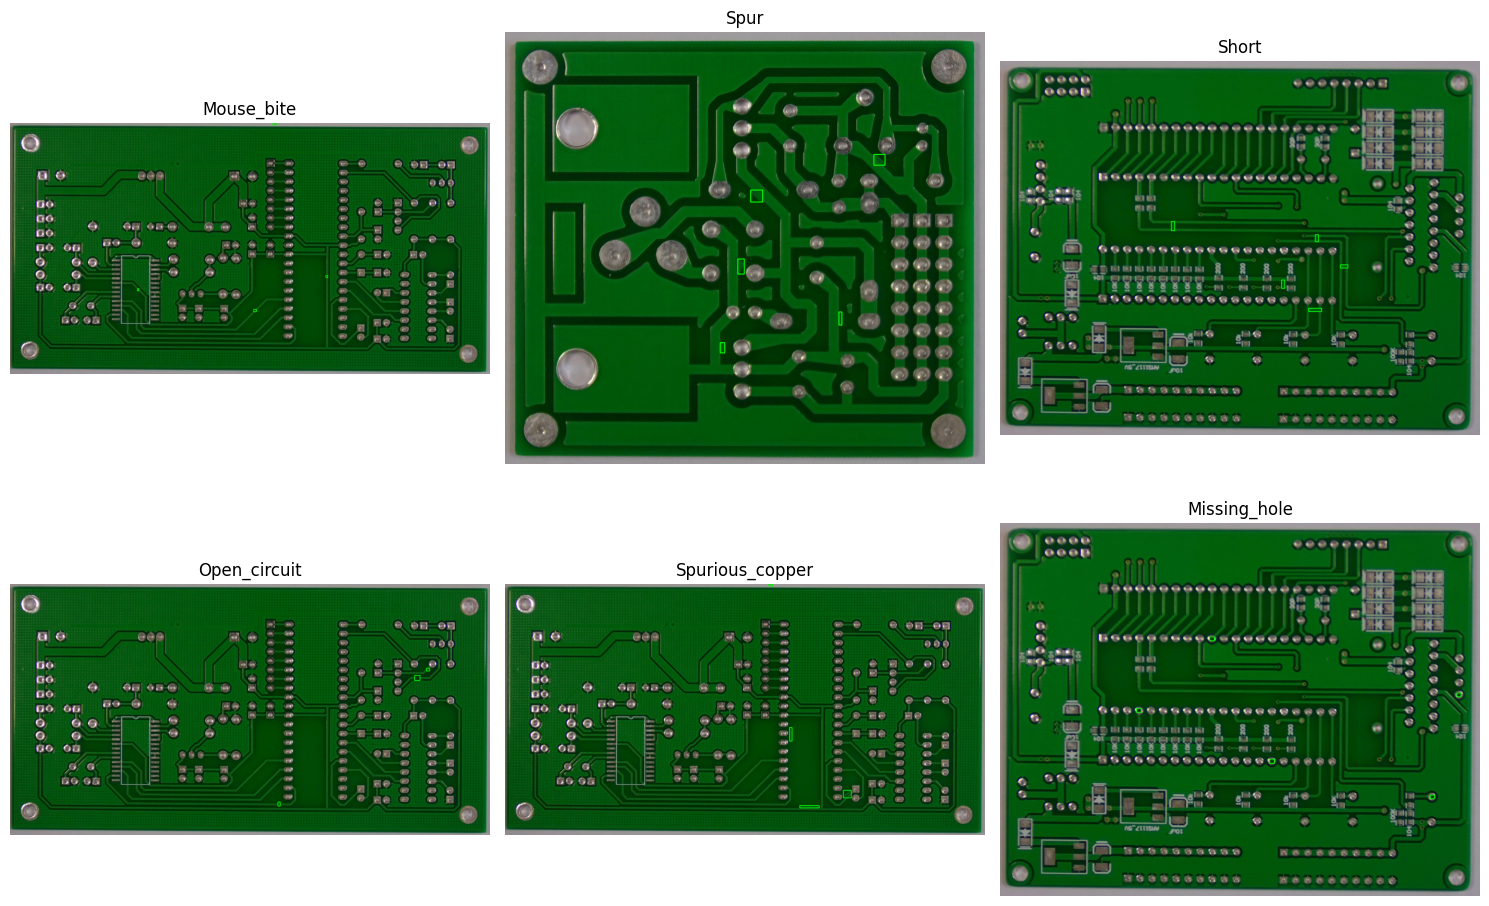

💾 ROI Dataset saved to Drive: defect_crops_final.zip


In [ ]:
print("\n🚀 Starting ROI Extraction...")

total_crops = 0
samples_for_viz = []

categories = [d for d in os.listdir(MASKS_DIR) if os.path.isdir(os.path.join(MASKS_DIR, d))]

for cat in categories:
    mask_path_cat = os.path.join(MASKS_DIR, cat)
    img_path_cat = os.path.join(IMAGES_DIR, cat)
    save_path_cat = os.path.join(OUTPUT_CROPS_DIR, cat)
    os.makedirs(save_path_cat, exist_ok=True)

    # Find all masks
    mask_files = glob.glob(f"{mask_path_cat}/*.png") + glob.glob(f"{mask_path_cat}/*.jpg")

    for m_file in tqdm(mask_files, desc=f"Processing {cat}"):
        # Load Mask
        mask = cv2.imread(m_file, 0)

        base_name = os.path.basename(m_file).replace("_mask", "").split('.')[0]
        org_img_path = None
        for ext in [".jpg", ".JPG"]:
            p = os.path.join(img_path_cat, base_name + ext)
            if os.path.exists(p):
                org_img_path = p
                break

        if not org_img_path: continue
        original_img = cv2.imread(org_img_path)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        viz_img = original_img.copy() if len(samples_for_viz) < 6 and cat not in [x[0] for x in samples_for_viz] else None

        for i, cnt in enumerate(contours):
            if cv2.contourArea(cnt) < MIN_AREA: continue

            x, y, w, h = cv2.boundingRect(cnt)

            h_img, w_img = original_img.shape[:2]
            y1, y2 = max(0, y-PADDING), min(h_img, y+h+PADDING)
            x1, x2 = max(0, x-PADDING), min(w_img, x+w+PADDING)

            crop = original_img[y1:y2, x1:x2]

            if crop.size == 0: continue

            final_roi = resize_pad_square(crop, ROI_SIZE)

            cv2.imwrite(f"{save_path_cat}/{base_name}_{i}.png", final_roi)
            total_crops += 1

            if viz_img is not None:
                cv2.rectangle(viz_img, (x, y), (x+w, y+h), (0, 255, 0), 3)

        if viz_img is not None:
            samples_for_viz.append((cat, viz_img))

print(f"\n✅ Module 2 Complete. Extracted {total_crops} Clean ROIs.")
print("\n--- Deliverable: Defect Localization ---")
plt.figure(figsize=(15, 10))
for idx, (label, img) in enumerate(samples_for_viz):
    plt.subplot(2, 3, idx+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

!zip -q -r /content/defect_crops_final.zip {OUTPUT_CROPS_DIR}
!cp /content/defect_crops_final.zip /content/drive/MyDrive/CircuitGuard_Project/
print("💾 ROI Dataset saved to Drive: defect_crops_final.zip")